# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### 1. Define the problem 

**This Jupyter Notebook loads, explores, and visualizes the salary prediction datasets. Also, builds and tests several predictive models, and then makes salary predictions on test data using the best model.**

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.utils import shuffle

% matplotlib inline

UsageError: Line magic function `%` not found.


## Part 2 - DISCOVER

### 2. Load the data and Examine the data

In [2]:
#Load csv file to pd dataframe
def load_data(file):
    return pd.read_csv(file)
train_feature_df = load_data('train_features.csv')
train_target_df = load_data('train_salaries.csv')
test_feature_df = load_data('test_features.csv')

#### <font color=green>*Examine the data*</font>

In [3]:
train_feature_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68


In [4]:
print(train_feature_df.shape)
print(train_target_df.shape)
print(test_feature_df.shape)

(1000000, 8)
(1000000, 2)
(1000000, 8)


In [5]:
train_target_df.head(10)


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163
5,JOB1362684407692,113
6,JOB1362684407693,178
7,JOB1362684407694,73
8,JOB1362684407695,31
9,JOB1362684407696,104


In [6]:
missing_data = train_feature_df.isnull().sum()
missing_data

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [7]:
test_feature_df.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [8]:
train_feature_df.degree.value_counts()

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64

In [9]:
train_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [10]:
train_feature_df.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


#### *Merge two dataframes*

In [11]:
#Consolidate training data: Performing inner join and getting uniq rows from both dataframe
def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index) 

In [12]:
raw_train_df = consolidate_data(train_feature_df, train_target_df, key='jobId') 
raw_train_df.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


### 3. Clean the data

#### *Check for Duplicates*

In [13]:
raw_train_df.duplicated().sum()

0

In [14]:
test_feature_df.duplicated().sum()

0

#### *Check for NONE values*

In [15]:
train_feature_df.query('major == "NONE"').major.count()
#--------------OR----------------------
#train_feature_df.loc[train_feature_df.major == 'NONE', 'major'].value_counts()

532355

#### *Check invalid or corrupt data and remove it*

In [16]:
'''remove rows that contain salary <= 0 or duplicate job IDs'''
def clean_data(raw_df):
    clean_df = raw_df.drop_duplicates(subset='jobId')
    clean_df = clean_df[clean_df.salary > 0]
    return clean_df

In [17]:
'''Shuffle, and reindex training data -- shuffling improves cross-validation accuracy'''
clean_train_df = shuffle(clean_data(raw_train_df)).reset_index()
clean_train_df.head()

,index,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,326215,JOB1362684733902,COMP14,JUNIOR,DOCTORAL,BIOLOGY,WEB,21,94,101
1,38823,JOB1362684446510,COMP28,MANAGER,BACHELORS,NONE,WEB,20,90,104
2,240322,JOB1362684648009,COMP26,JUNIOR,BACHELORS,BUSINESS,SERVICE,17,9,99
3,317835,JOB1362684725522,COMP7,MANAGER,HIGH_SCHOOL,NONE,AUTO,2,92,91
4,669917,JOB1362685077604,COMP39,JUNIOR,DOCTORAL,NONE,WEB,20,34,117


### 4. Explore the data (EDA) 

In [18]:
'''Divide varables in categorical and numerical'''
categorical_vars = ['companyId','jobType','degree','major','industry']
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'    

#### *summarize numeric feature variable*

In [19]:
clean_train_df.describe(include=[np.number])

,index,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000,999995.000000
mean,499999.177092,11.992407,49.529381,116.062398
std,288675.219219,7.212390,28.877721,38.717163
min,0.000000,0.000000,0.000000,17.000000
25%,249999.500000,6.000000,25.000000,88.000000
50%,499999.000000,12.000000,50.000000,114.000000
75%,749998.500000,18.000000,75.000000,141.000000
max,999999.000000,24.000000,99.000000,301.000000


#### *summarize categorical feature variable*

In [20]:
clean_train_df.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362685245114,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


#### summarize target variable*

#### Merge categorical and numerical variables data

In [21]:
def merge_cat_num_data(df1,df2):# cat_vars=None, num_vars=None):
    train_df = pd.merge(df1, df2)
    return train_df 
merged_data = merge_cat_num_data(clean_train_df,train_target_df)
clean_train_df.head(5)

,index,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,326215,JOB1362684733902,COMP14,JUNIOR,DOCTORAL,BIOLOGY,WEB,21,94,101
1,38823,JOB1362684446510,COMP28,MANAGER,BACHELORS,NONE,WEB,20,90,104
2,240322,JOB1362684648009,COMP26,JUNIOR,BACHELORS,BUSINESS,SERVICE,17,9,99
3,317835,JOB1362684725522,COMP7,MANAGER,HIGH_SCHOOL,NONE,AUTO,2,92,91
4,669917,JOB1362685077604,COMP39,JUNIOR,DOCTORAL,NONE,WEB,20,34,117


In [22]:
clean_train_df.nunique()


index                  999995
jobId                  999995
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    279
dtype: int64

#### Find Correction of variables

In [23]:
def get_correlation(df):
    return df.corr()

corr_matrix = get_correlation(clean_train_df)
corr_matrix["salary"].sort_values(ascending=False)


salary                 1.000000
yearsExperience        0.375013
index                 -0.000790
milesFromMetropolis   -0.297686
Name: salary, dtype: float64

### 5. Visualize target variable (Salary) 

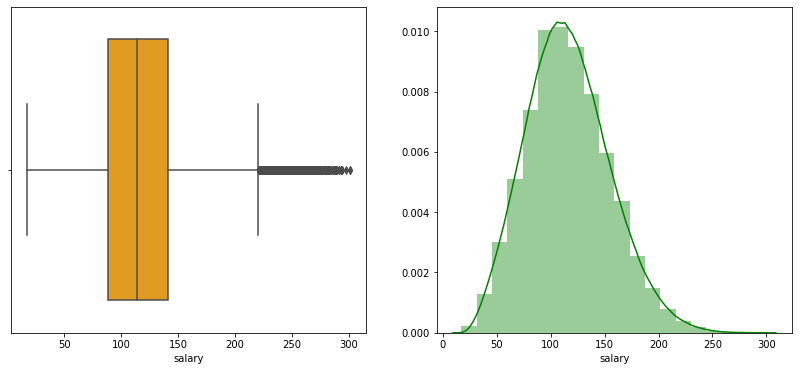

In [24]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(merged_data.salary, color ='Orange')
plt.subplot(1,2,2)
sns.distplot(merged_data.salary, bins=20, color='green')
plt.show()

#### *Use IQR rule to identify potential outliers*

In [25]:
stat = clean_train_df.salary.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


#### *Examine potential outliners*

In [26]:
# Check potential outliner below lower bound
print(clean_train_df[clean_train_df.salary < 8.5])

Empty DataFrame
Columns: [index, jobId, companyId, jobType, degree, major, industry, yearsExperience, milesFromMetropolis, salary]
Index: []


In [27]:
# Check potential outliner over upper bound
clean_train_df.loc[clean_train_df.salary > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [28]:
# Check suspicions potential outliner above upper bound
clean_train_df[(clean_train_df.salary > 220.5) & (clean_train_df.jobType == 'JUNIOR')]

,index,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
29444,627534,JOB1362685035221,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
62649,348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
221626,500739,JOB1362684908426,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
224804,427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221
414029,214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
433498,160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
444362,855219,JOB1362685262906,COMP13,JUNIOR,MASTERS,ENGINEERING,OIL,22,26,225
473085,1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
583625,656572,JOB1362685064259,COMP28,JUNIOR,DOCTORAL,BUSINESS,OIL,22,3,222
682703,645555,JOB1362685053242,COMP36,JUNIOR,DOCTORAL,BUSINESS,FINANCE,24,1,225


Zero salaries are instances of missing/corrupt data and should be removed from the training set, because they do not appear to be volunteer positions

The high-salary potential outliers have C-level executive roles, and the junior positions are in industries that are well known for high salaries (oil, finance). We determine these entries to be legitimate and will not remove them.

In [29]:
# Remove data with zero salaries.
clean_train_df = clean_train_df[clean_train_df.salary > 8.5]
clean_train_df.head()

,index,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,326215,JOB1362684733902,COMP14,JUNIOR,DOCTORAL,BIOLOGY,WEB,21,94,101
1,38823,JOB1362684446510,COMP28,MANAGER,BACHELORS,NONE,WEB,20,90,104
2,240322,JOB1362684648009,COMP26,JUNIOR,BACHELORS,BUSINESS,SERVICE,17,9,99
3,317835,JOB1362684725522,COMP7,MANAGER,HIGH_SCHOOL,NONE,AUTO,2,92,91
4,669917,JOB1362685077604,COMP39,JUNIOR,DOCTORAL,NONE,WEB,20,34,117


In [30]:
def plot_feature(df, col):
    '''
    Make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of salary on the feature
    '''
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1, 2, 2)

    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df)
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.show()

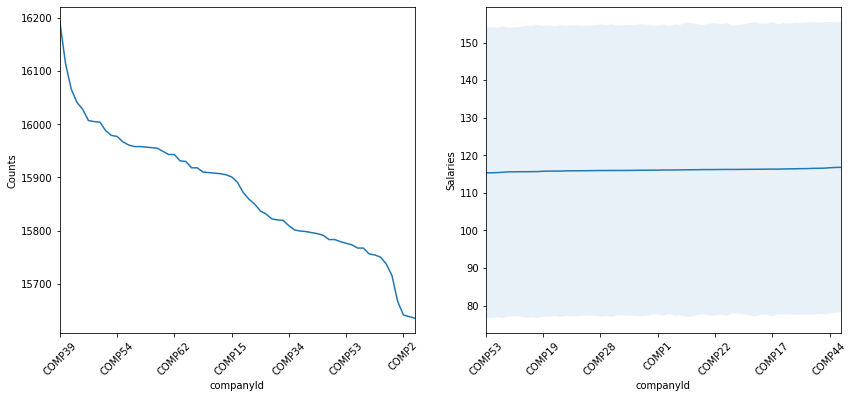

In [31]:
plot_feature(clean_train_df, 'companyId')

`The salary is weakly associated with companies.`

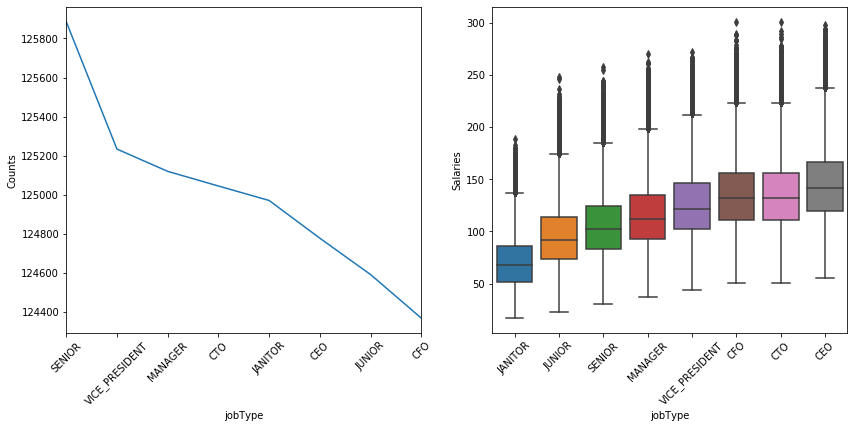

In [32]:
plot_feature(clean_train_df, 'jobType')

`There is a clear positive correlation between job type and salary.`

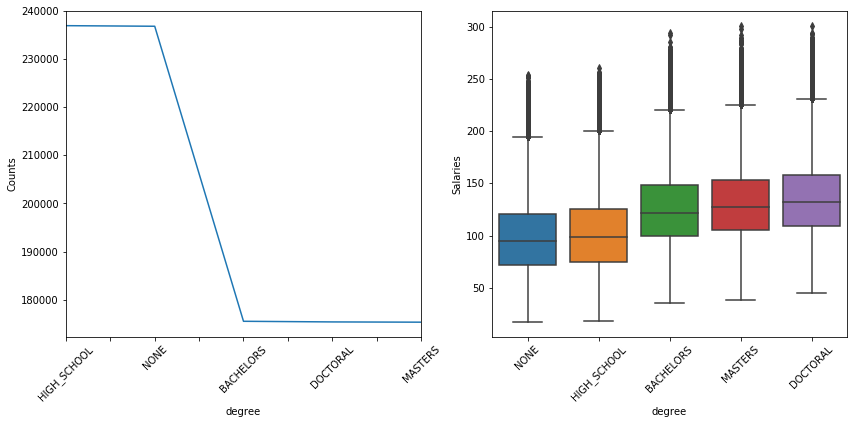

In [33]:
plot_feature(clean_train_df, 'degree')

`More advanced degrees tend to correspond to higher salaries.`

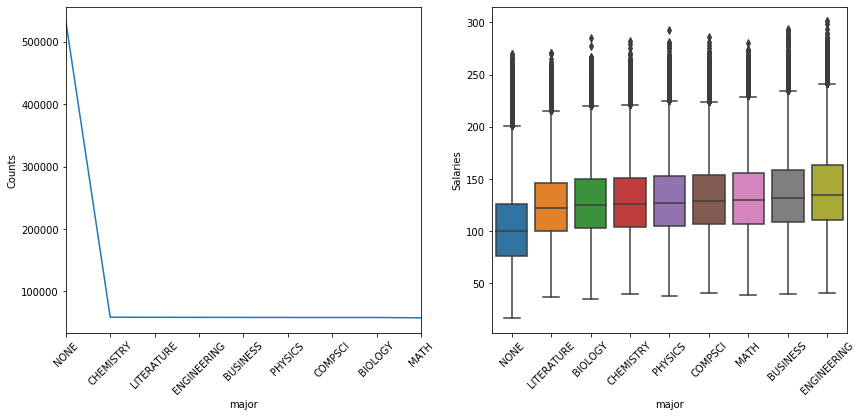

In [34]:
plot_feature(clean_train_df, 'major')

`People with majors of engineering, business and math generally have higher salaries.`

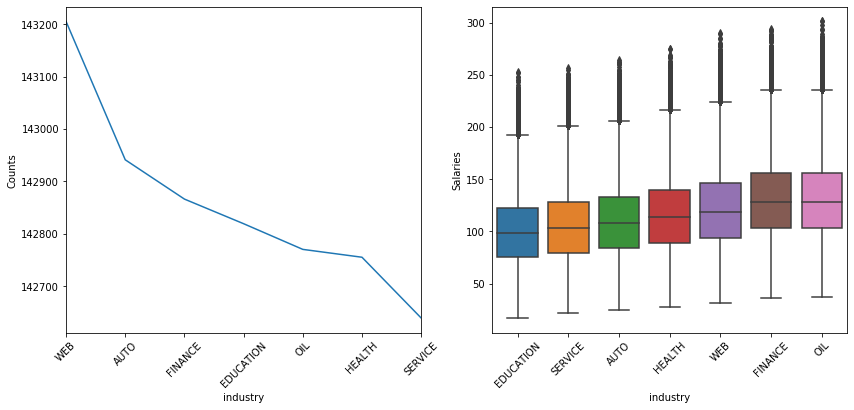

In [35]:
plot_feature(clean_train_df, 'industry')

`As for industries, oil, finance and web industries generally pay better.`

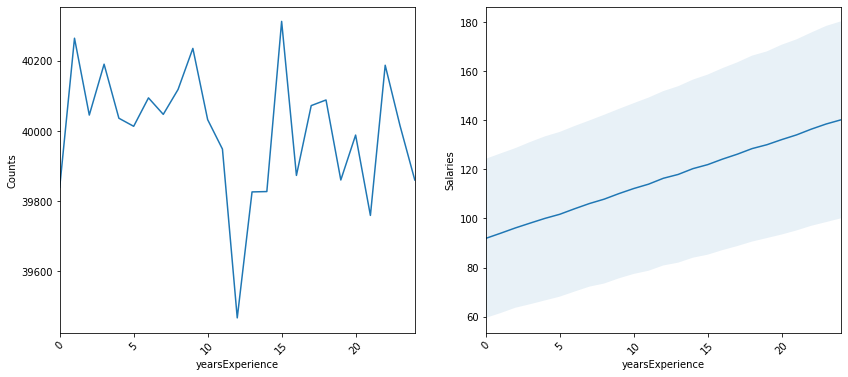

In [36]:
plot_feature(clean_train_df, 'yearsExperience')

`In general, there is a clear correlation between salary and years of experience.`

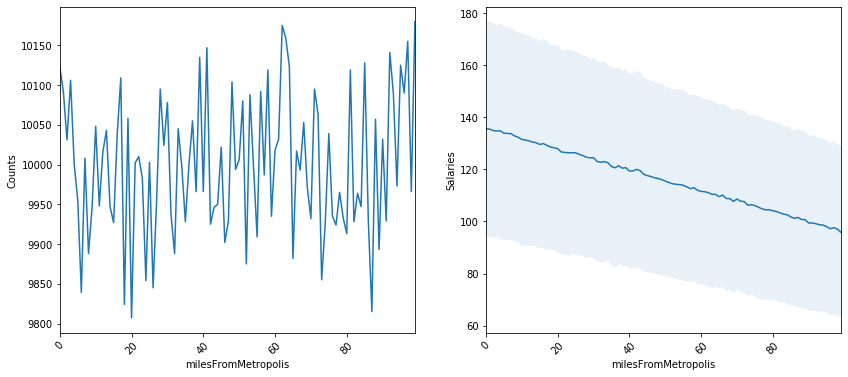

In [37]:
plot_feature(clean_train_df, 'milesFromMetropolis')

`In general, salaries decrease with the distance to metropolis.`

### 6. Establish a baseline 

#### *Concat categorical variables and combine result with numerical variables*

In [38]:
def concat_cat_num_data(df, cat_vars=None, num_vars=None):
    '''concat all categorical variables and combines result with numerical variables'''
    cat_df = pd.get_dummies(df[cat_vars], drop_first=True)
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)
feature_df = concat_cat_num_data(clean_train_df, cat_vars=categorical_vars, num_vars=numeric_vars)
test_df = concat_cat_num_data(test_feature_df, cat_vars=categorical_vars, num_vars=numeric_vars)

In [39]:
# Remove jobId and companyId
clean_train_df.drop('index', axis=1, inplace=True)
clean_train_df.drop('jobId', axis=1, inplace=True)
clean_train_df.drop('companyId', axis=1, inplace=True)

clean_train_df.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JUNIOR,DOCTORAL,BIOLOGY,WEB,21,94,101
1,MANAGER,BACHELORS,NONE,WEB,20,90,104
2,JUNIOR,BACHELORS,BUSINESS,SERVICE,17,9,99
3,MANAGER,HIGH_SCHOOL,NONE,AUTO,2,92,91
4,JUNIOR,DOCTORAL,NONE,WEB,20,34,117


In [40]:
# One-hot encode categorical data in train_data dataset
oenHot_data= pd.get_dummies(clean_train_df[['jobType','degree','major','industry']], drop_first= True)
clean_train_df.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JUNIOR,DOCTORAL,BIOLOGY,WEB,21,94,101
1,MANAGER,BACHELORS,NONE,WEB,20,90,104
2,JUNIOR,BACHELORS,BUSINESS,SERVICE,17,9,99
3,MANAGER,HIGH_SCHOOL,NONE,AUTO,2,92,91
4,JUNIOR,DOCTORAL,NONE,WEB,20,34,117


In [41]:
clean_train_df.drop('jobType', axis=1, inplace=True)
clean_train_df.drop('degree', axis=1, inplace=True)
clean_train_df.drop('major', axis=1, inplace=True)
clean_train_df.drop('industry', axis=1, inplace=True)
clean_train_df.head()

,yearsExperience,milesFromMetropolis,salary
0,21,94,101
1,20,90,104
2,17,9,99
3,2,92,91
4,20,34,117


In [42]:
final_data = pd.concat([clean_train_df, oenHot_data], axis=1)#,ignore_index=False)
final_data.shape

(999995, 28)

In [43]:
X = final_data[final_data.loc[ : , final_data.columns != 'salary'].columns]
y = final_data['salary']

In [52]:
X.columns

Index(['yearsExperience', 'milesFromMetropolis', 'jobType_JUNIOR',
       'jobType_SENIOR', 'jobType_MANAGER', 'jobType_VICE_PRESIDENT',
       'jobType_CFO', 'jobType_CTO', 'jobType_CEO', 'degree_HIGH_SCHOOL',
       'degree_BACHELORS', 'degree_MASTERS', 'degree_DOCTORAL',
       'major_LITERATURE', 'major_BIOLOGY', 'major_CHEMISTRY', 'major_PHYSICS',
       'major_COMPSCI', 'major_MATH', 'major_BUSINESS', 'major_ENGINEERING',
       'industry_SERVICE', 'industry_AUTO', 'industry_HEALTH', 'industry_WEB',
       'industry_FINANCE', 'industry_OIL'],
      dtype='object')

## Part 3 - DEVELOP

### Create model

In [44]:
#create Linear Regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [45]:
regressor = LinearRegression()

#Fitting model with trainig data
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
# View coefficients of linear regression object
print(regressor.intercept_)
print(regressor.coef_)

48.20125070524169
[ 2.01047642 -0.40028849 12.50529337 22.56724578 32.48839506 42.41570556
 52.56555861 52.57355239 62.31557771  3.69054121  9.44165531 14.48206347
 19.48549389  1.28488929  4.95413884  5.90261777  7.26518969  8.87042386
 10.08840568 12.61797617 15.56757107  5.0359251  10.01632113 16.2568822
 22.10766891 31.11924873 31.28919728]


In [47]:
# Make predictions using the testing set
y_pred = regressor.predict(X_test)

In [48]:
print("The mean squared error of our test set predicitons is:", mean_squared_error(y_test, y_pred))

The mean squared error of our test set predicitons is: 384.6062705368216


In [49]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor, X_test, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (test data):", (np.mean(scores)), (np.std(scores)))

5-Fold Cross Validation Accuracy (test data): 0.7425689107738328 0.0012529079373936845


In [50]:
print("R-squared of test data:", regressor.score(X_test, y_test))

R-squared of test data: 0.7426079162098655


In [51]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 15.84484053628951
Mean Squared Error: 384.6062705368216
Root Mean Squared Error: 19.61138114811962


## Part 4 - DEPLOY

### Deploy solution 

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders